## The aim of this script is to

- 1 download data from yahoo finance, do a basic process

- 2 set up a DataFrame to do back testing, use available data to estimate value

- 3 simulate the strategy of delta hedging: buy put and hedge by stock, including other consideration like _change of strike, time colapse, transaction fee_

In [1]:
import numpy as np
from numpy import exp, log, sqrt
from scipy.stats import norm, linregress

import pandas as pd
import pandas_datareader as pdr
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import seaborn as sns
sns.set()

import warnings
warnings.simplefilter(action='ignore', category=Warning) # so you wont be bother by informal assignment to DataFrame

In [2]:
# load the close price of a desire asset
ticker = 'AAPL'
start, end = pd.datetime(2015,1,1), pd.datetime.now()
raw = pdr.get_data_yahoo(ticker, start, end)
raw = raw[['Adj Close']]
raw.columns = ['stock_val']

# compute return and historical vol, used to estimate the implied vol in market
raw['ret'] = raw.stock_val / raw.stock_val.shift() - 1
raw['vol'] = raw.ret.rolling(window = 60).std() * sqrt(250)
raw = raw.dropna()
del raw['ret']

In [3]:
raw

,stock_val,vol
Date,,
2015-03-30,115.97924,0.27595
2015-03-31,114.19875,0.27727
2015-04-01,114.03356,0.27007
2015-04-02,115.01556,0.27027
2015-04-06,116.87865,0.27068
...,...,...
2020-07-27,379.23999,0.26283
2020-07-28,373.01001,0.26294
2020-07-29,380.16000,0.26392


In [4]:
# slice a test range
test_start, test_end = pd.datetime(2019,4,30), pd.datetime(2020,4,30)
data = raw.loc[test_start:test_end]
data

,stock_val,vol
Date,,
2019-04-30,197.54262,0.17825
2019-05-01,207.23912,0.19484
2019-05-02,205.89046,0.19386
2019-05-03,208.44995,0.19468
2019-05-06,205.23091,0.19310
...,...,...
2020-04-24,282.20609,0.71306
2020-04-27,282.40555,0.71307
2020-04-28,277.82791,0.70816


## Backtesting

In [5]:
# create columns for recording position, greek and pnl
# some must be a float(0), or dtype will be int

def add_col(df, col, default_value=0):
    df[col] = default_value
    return df[col]

K = add_col(data, 'K', 0) # assign the col to a variable, so we dont need to write data again and again
opt_pos = add_col(data, 'opt_pos', 0)
stock_pos = add_col(data, 'stock_pos', 0)

opt_val, delta, cash, h_cost, pnl = (add_col(data, col, 0.) for col in ['opt_val', 'delta', 'cash', 'h_cost', 'pnl'])

stock_val = data['stock_val']
vol = data['vol']

data.head()

,stock_val,vol,K,opt_pos,stock_pos,opt_val,delta,cash,h_cost,pnl
Date,,,,,,,,,,
2019-04-30,197.54262,0.17825,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000
2019-05-01,207.23912,0.19484,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000
2019-05-02,205.89046,0.19386,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000
2019-05-03,208.44995,0.19468,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000
2019-05-06,205.23091,0.19310,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000


In [6]:
def BSM_Eur_Opt(isCall, S, K, r, q, T, sig, withgreek = False):
    '''Compute European option price w/wo greeks'''
    if sig == 0. or T == 0.:
        return max(S-K,0) if isCall else max(K-S,0)
    
    K = float(K)
    
    sqrtT = sqrt(T)
    ert = exp(-r*T)
    eqt = exp(-q*T)
    
    d1      = (log(S/K) + (r-q+0.5*sig**2)*T) / (sig*sqrtT)
    d2      = d1 - sig*sqrtT
    nd1     = norm.cdf(d1)
    nd2     = norm.cdf(d2)
    neg_nd1 = norm.cdf(-d1)
    neg_nd2 = norm.cdf(-d2)
    der_nd1 = norm.pdf(d1)
    
    call =   S * nd1     * eqt - K * nd2     * ert
    put  = - S * neg_nd1 * eqt + K * neg_nd2 * ert
    
    if not withgreek:
        return call if isCall else put
    else:
        callset = {'price':call}
        putset  = {'price':put}
        
        callset['delta'] = eqt*nd1
        putset['delta'] = eqt*(nd1-1)

        callset['gamma'] = putset['gamma'] = eqt*der_nd1 / (S*sig*sqrtT)

        callset['theta'] = -S*der_nd1*sig*eqt/(2*sqrtT) + q*S*eqt*nd1 - r*K*ert*nd2
        putset['theta'] = -S*der_nd1*sig*eqt/(2*sqrtT) + q*S*eqt*neg_nd1 + r*K*ert*neg_nd2

        callset['vega'] = putset['vega'] = S * sqrtT * der_nd1* eqt

        callset['rho'] = K*T*ert*nd2
        putset['rho'] = -K*T*ert*neg_nd2
        
        return callset if isCall else putset

def roundtonum(price, num):
    return num * round(price/num)

In [7]:
#### initiate parameters
isCall, r, q, T = False, 0.04, 0.02, 0.25

perfect_trade = False # we need to pay fees for broker
interest = 0 if perfect_trade else 0.04
vol_charge = 0 if perfect_trade else 0.01
stock_charge = 0 if perfect_trade else 0.003

perfect_hedge = False # due to minimum trading quantity, we may not perfectly hedge our delta position
option_rounding = 0.001 if perfect_hedge else 5
stock_rounding = 0.001 if perfect_hedge else 100

In [8]:
# first period, initiate our position
# choose a strike to buy in the put
K[0] = roundtonum(stock_val[0], option_rounding)
# calculate the value of th put
opt_val[0] = BSM_Eur_Opt(isCall, stock_val[0], K[0], r, q, T, vol[0])
# how many position we would like to long in put
# instead of opt_pos[0] = 10000, we will hold to maturity and do not change the position
opt_pos[:] = 10000 

# calculate the delta of the put
delta[0] = BSM_Eur_Opt(isCall, stock_val[0], K[0], r, q, T, vol[0], True)['delta']
# delta hedge the put
stock_pos[0] = - roundtonum(opt_pos[0] * delta[0], stock_rounding)
# calculate cash position, no pnl change at beginning
cash[0] = - opt_val[0] * opt_pos[0] - stock_val[0] * stock_pos[0]

# initial cost
h_cost[0] = stock_charge * stock_val[0] * stock_pos[0]
h_cost[0] += (BSM_Eur_Opt(isCall, stock_val[0], K[0], r, q, T, vol[0] + vol_charge) -
              BSM_Eur_Opt(isCall, stock_val[0], K[0], r, q, T, vol[0] + vol_charge)) * opt_pos[0]
pnl[0] -= h_cost[0]

data.head()

,stock_val,vol,K,opt_pos,stock_pos,opt_val,delta,cash,h_cost,pnl
Date,,,,,,,,,,
2019-04-30,197.54262,0.17825,200,10000,5100,7.76238,-0.51261,-1085091.17767,3022.40205,-3022.40205
2019-05-01,207.23912,0.19484,0,10000,0,0.00000,0.00000,0.00000,0.00000,0.00000
2019-05-02,205.89046,0.19386,0,10000,0,0.00000,0.00000,0.00000,0.00000,0.00000
2019-05-03,208.44995,0.19468,0,10000,0,0.00000,0.00000,0.00000,0.00000,0.00000
2019-05-06,205.23091,0.19310,0,10000,0,0.00000,0.00000,0.00000,0.00000,0.00000


In [9]:
T = 0.25 # we also consider the change of maturity, theta loss

for i in range(1,len(data)):
    # new day begins
    old_T = T
    T -=  1/250
    cash[i] = cash[i-1]
    h_cost[i] = h_cost[i-1]
    K[i] = K[i-1]
    
    # daily change in option
    opt_val[i] = BSM_Eur_Opt(isCall, stock_val[i], K[i], r, q, T, vol[i])
    
    # option and stock pnl
    pnl[i] = pnl[i-1] + opt_pos[i-1] * (opt_val[i] - opt_val[i-1])
    pnl[i] += stock_pos[i-1] * (stock_val[i] - stock_val[i-1])
    
    # interest
    pnl[i] += cash[i-1] * (data.index[i] - data.index[i-1]).days/365 * interest
    
    # change option(change of strike or roll over the maturity)
    cur_delta = BSM_Eur_Opt(isCall, stock_val[i], K[i], r, q, T, vol[i], True)['delta']
    deltaflag = 0.2 > abs(cur_delta) or 0.7 < abs(cur_delta)
    timeflag  = T < 0.04
    
    if perfect_hedge or deltaflag or timeflag:
        # calculate the new strike/ new maturity
        K[i] = roundtonum(stock_val[i], option_rounding)
        if timeflag:
            old_T, T = T, 0.25

        # calculate the new option price
        opt_val[i] = BSM_Eur_Opt(isCall, stock_val[i], K[i], r, q, T, vol[i])
        cash[i] -= opt_pos[i] * (opt_val[i] - opt_val[i])
        
        # cost of changing option
        option_cost = (BSM_Eur_Opt(isCall, stock_val[i], K[i], r, q, old_T, vol[i]) - 
                       BSM_Eur_Opt(isCall, stock_val[i], K[i], r, q, old_T, vol[i] - vol_charge))
        option_cost += (BSM_Eur_Opt(isCall, stock_val[i], K[i], r, q, T, vol[i] + vol_charge) - 
                        BSM_Eur_Opt(isCall, stock_val[i], K[i], r, q, T, vol[i]))
        h_cost[i] += option_cost * opt_pos[i]
        pnl[i] -= option_cost * opt_pos[i]
        
    # daily rebalancing according to the new delta
    delta[i] = BSM_Eur_Opt(isCall, stock_val[i], K[i], r, q, T, vol[i], True)['delta']
    stock_pos[i] = - roundtonum(opt_pos[i] * delta[i], stock_rounding)
    
    # cash change, if we have changed option then no need to based on cash[i-1]
    cash[i] -= (stock_pos[i]-stock_pos[i-1]) * stock_val[i]
    
    # cost of buying/selling stock
    stock_cost = stock_charge * stock_val[i] * abs(stock_pos[i] - stock_pos[i-1])
    pnl[i] -= stock_cost
    h_cost[i] += stock_cost


In [10]:
data

,stock_val,vol,K,opt_pos,stock_pos,opt_val,delta,cash,h_cost,pnl
Date,,,,,,,,,,
2019-04-30,197.54262,0.17825,200,10000,5100,7.76238,-0.51261,-1085091.17767,3022.40205,-3022.40205
2019-05-01,207.23912,0.19484,200,10000,3200,4.37245,-0.31862,-691336.84875,4203.66504,11230.22807
2019-05-02,205.89046,0.19386,200,10000,3400,4.72903,-0.34189,-732514.94018,4327.19931,10281.05539
2019-05-03,208.44995,0.19468,200,10000,3000,3.89091,-0.29549,-649134.95971,4577.33925,10271.70210
2019-05-06,205.23091,0.19310,200,10000,3500,4.82285,-0.35284,-751750.41534,4885.18562,9412.71263
...,...,...,...,...,...,...,...,...,...,...
2020-04-24,282.20609,0.71306,250,10000,2600,11.14417,-0.25574,-293354.43450,247522.65586,198057.54267
2020-04-27,282.40555,0.71307,250,10000,2500,10.69377,-0.25208,-265113.87969,247607.37752,193890.95137
2020-04-28,277.82791,0.70816,250,10000,2700,11.34458,-0.27263,-320679.46197,247774.07427,188759.23002


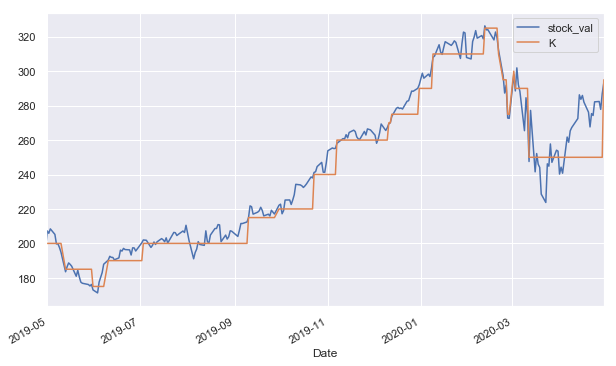

In [11]:
# plot the graph to see how revenue changes
# ax = data[['stock_val','K','h_cost', 'pnl']].plot(figsize = (10,6), secondary_y=['pnl','h_cost']) # no change strike
data[['stock_val','K']].plot(figsize = (10,6))

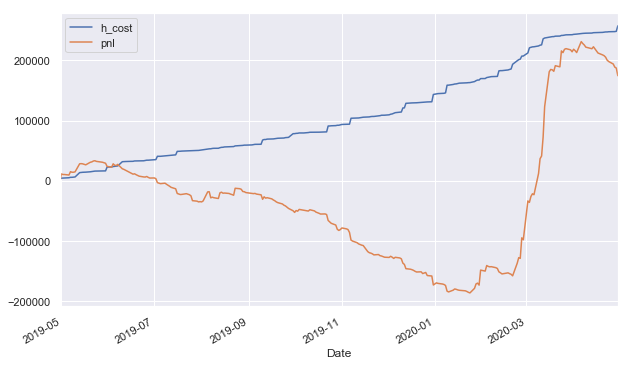

In [12]:
data[['h_cost', 'pnl']].plot(figsize = (10,6))

## Performance analysis

In [13]:
# Assume full funded to do a performance analysis
portfolio = pnl - cash[0]

In [14]:
result = pd.DataFrame(columns = ['Delta Hedge'])

port_return = (portfolio.shift()/portfolio-1).dropna()

result.loc['return'] = portfolio[-1]/portfolio[0] - 1
result.loc['std'] = port_return.std() * sqrt(250)
result.loc['Sharpe Ratio'] = (result.loc['return']-interest)/result.loc['std']

result.loc['Maximum Drawdown'] = min(portfolio / portfolio.expanding().max()) - 1

In [15]:
stock_return = (stock_val.shift()/stock_val-1).dropna()
params = linregress(stock_return, port_return)
result.loc['beta'] = params[0]

result.loc["Treynor's ratio"] = (result.loc['return']-interest)/result.loc['beta']

# active_port = port_return - stock_return
# active_port.mean()/active_port.std()

In [16]:
result

,Delta Hedge
return,0.16404
std,0.12645
Sharpe Ratio,0.98094
Maximum Drawdown,-0.19643
beta,-0.03286
Treynor's ratio,-3.77539
